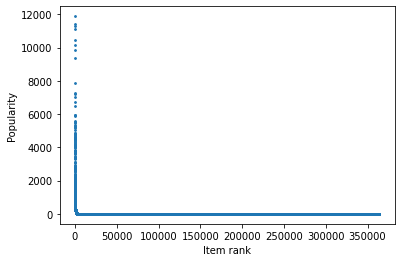

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = './tcdata'
train_data = np.loadtxt(data_dir + '/train_click_log.csv', skiprows=1, delimiter=',')
test_data = np.loadtxt(data_dir + '/testA_click_log.csv', skiprows=1, delimiter=',')
articles = np.loadtxt(data_dir + '/articles.csv', skiprows=1, delimiter=',')
train_users = np.array(train_data[:, 0], dtype=int)
train_items = np.array(train_data[:, 1], dtype=int)
test_users = np.array(test_data[:, 0], dtype=int)
test_items = np.array(test_data[:, 1], dtype=int)

pop_item = np.bincount(train_items)
pop_item_sort = sorted(pop_item, reverse=True)
X = np.array(range(len(pop_item)))

area = np.pi * 1**2
plt.scatter(X, pop_item_sort, s=area)
plt.xlabel('Item rank')
plt.ylabel('Popularity')
plt.show()

## 训练集分析

In [41]:
train_data.shape

(1112623, 9)

有 111 万条交互数据

这批新闻数据长尾分布非常严重，即存在很大的流行度偏差。

In [49]:
train_user_num = np.unique(train_users).shape[0]
train_item_num = np.unique(train_items).shape[0]
item_num = articles.shape[0]
print('训练集中：')
print('user_num: {}, item_num: {}'.format(train_user_num, train_item_num))
print('the number of total items: ', item_num)
print('最小用户id: {}, 最大用户id: {},最小新闻id: {}, 最大新闻id: {}'.format(train_users.min(), train_users.max(), train_items.min(), train_items.max()))

训练集中：
user_num: 200000, item_num: 31116
the number of total items:  364047
最小用户id: 0, 最大用户id: 199999,最小新闻id: 3, 最大新闻id: 364046


用户数有20万个，新闻有30万多个。说明有的新闻没有交互记录。

In [52]:
train_sparsity = train_data.shape[0] / (train_user_num * train_item_num)
train_sparsity

0.00017878631572181515

数据非常的稀疏。

## 测试集分析

In [46]:
test_data.shape

(518010, 9)

相比于训练集的 111 万条交互数据，测试集中有约 52 万条交互数据。

In [51]:
test_user_num = np.unique(test_users).shape[0]
test_item_num = np.unique(test_items).shape[0]
print('测试集中：')
print('user_num: {}, item_num: {}'.format(test_user_num, test_item_num))
print('the number of total items: ', item_num)
print('最小用户id: {}, 最大用户id: {},最小新闻id: {}, 最大新闻id: {}'.format(test_users.min(), test_users.max(), test_items.min(), test_items.max()))

测试集中：
user_num: 50000, item_num: 16330
the number of total items:  364047
最小用户id: 200000, 最大用户id: 249999,最小新闻id: 137, 最大新闻id: 364043


训练集用的是前 20 万用户的交互数据，测试集用的是后 5 万用户的交互数据。这个要咋训练呢？？都不是同一批用户

In [53]:
test_sparsity = test_data.shape[0] / (test_user_num * test_item_num)
test_sparsity

0.0006344274341702388

## 导包

In [55]:
import time
import math
import os
from tqdm import tqdm
import gc
import pickle
import random
from datetime import datetime
from operator import itemgetter
import warnings
from collections import defaultdict
import collections
warnings.filterwarnings('ignore')

In [106]:
data_path = './tcdata'

## df节省内存函数

In [101]:
# 节约内存的一个标配函数
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('--Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction), time spend: {:2.2f} min'.format(end_mem, 100*(start_mem-end_mem)/start_mem, (time.time()-starttime)/60))
    
    return df            
            
            

In [69]:
# math.isnan(*)
lists = [1, 2, np.nan, 3, np.nan-np.nan]
for l in lists:
    if math.isnan(l):
        print('It is nan!')

It is nan!
It is nan!


In [105]:
# 对函数 reduce_mem() 的测试
a = np.ones(100000000)*1000000
df = pd.DataFrame(a,columns=['num'])
df_red = reduce_mem(df)
# np.finfo(np.float32)

--Mem. usage decreased to 381.47 Mb (50.0% reduction), time spend: 0.01 min


## 读取采样或全量数据

In [109]:
# debug 模式：从训练集中划出一部分数据来调试代码
def get_all_click_sample(data_path, sample_nums=10000):
    """
        训练集中采样一部分数据调试
        data_path: 原数据的存储路径
        sample_nums: 采样数目（这里由于机器内存的限制，可以采样用户数）
    """
    all_click = pd.read_csv(data_path + '/train_click_log.csv')
    all_user_ids = all_click.user_id.unique()
    
    # 随机采样：np.random.choice()
    # 对50万用户进行随机采样，而不是对110万条交互数据
    sample_user_ids = np.random.choice(all_user_ids, size=sample_nums, replace=False)
    all_click = all_click[all_click['user_id'].isin(sample_user_ids)]  # 对行的筛选
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click
    
    

In [111]:
get_all_click_sample(data_path, 10000)

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
137,199955,233917,1507035772713,4,1,17,1,21,2
138,199955,272143,1507039745170,4,1,17,1,21,2
139,199955,235440,1507058383166,4,1,17,1,21,2
140,199955,206168,1507059667902,4,1,17,1,21,2
141,199955,70646,1507061041096,4,1,17,1,21,2
...,...,...,...,...,...,...,...,...,...
1112551,9,70986,1508211213614,4,3,2,1,25,2
1112552,9,211442,1508211245547,4,3,2,1,25,2
1112553,9,211455,1508211275547,4,3,2,1,25,2
1112573,5,211442,1508211243884,4,4,2,1,25,2


In [112]:
# 读取点击数据，这里分成线上和线下，如果是为了获取线上提交结果应该将测试集中的点击数据合并到总的数据中
# 如果是为了线下验证模型的有效性或者特征的有效性，可以只使用训练集
def get_all_click_df(data_path, offline=True):
    if offline:
        all_click = pd.read_csv(data_path + '/train_click_log.csv')
    else:
        trn_click = pd.read_csv(data_path + '/train_click_log.csv')
        tst_click = pd.read_csv(data_path + '/testA_click_log.csv')
        
        all_click = trn_click.append(tst_click)
        
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

In [160]:
# 全量训练
all_click_df = get_all_click_df(data_path, offline=False)
all_click_sample = get_all_click_sample(data_path, 10000)

## 获取 用户-文章-点击时间 字典

In [115]:
# 根据点击时间获取用户点击文章的序列  {user1: [(item1, time1), (item2, time2)...] ...}
# 说明数据是时序的
def get_user_item_time(click_df):
    click_df = click_df.sort_values('click_timestamp')
    
    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))
    
    user_item_time_df = click_df.groupby('user_id')['click_article_id','click_timestamp'].apply(lambda x: make_item_time_pair(x)).reset_index().rename(columns={0: 'item_time_list'})
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))
    
    return user_item_time_dict

In [161]:
get_user_item_time(all_click_sample)

{16: [(50644, 1508210982166), (211442, 1508211012166)],
 28: [(284470, 1508212151684), (224730, 1508212181684)],
 45: [(209122, 1508211252011), (211442, 1508211282011)],
 56: [(36162, 1508210347645), (294107, 1508210377645)],
 73: [(277107, 1508209310907),
  (352979, 1508209446804),
  (39894, 1508209546893),
  (308117, 1508209762719),
  (342473, 1508209792719)],
 118: [(50644, 1508208430406), (36162, 1508208460406)],
 176: [(79851, 1508208040000), (331116, 1508208070000)],
 202: [(211442, 1508213175116), (156279, 1508213205116)],
 222: [(50644, 1508206408791), (209122, 1508206438791)],
 230: [(211442, 1508206410050),
  (16346, 1508206757978),
  (331149, 1508207090042),
  (361585, 1508207385762),
  (330990, 1508207457215),
  (273348, 1508207921488),
  (270958, 1508208040445),
  (1973, 1508208236217),
  (362914, 1508208350237),
  (313257, 1508208464084),
  (360547, 1508208587196),
  (313556, 1508208675144),
  (332461, 1508208758369),
  (30389, 1508208788369)],
 259: [(16346, 150820631277

## 获取点击最多的topk个文章

In [156]:
# 获取近期点击最多的文章(第二种方法可以显示点击量)
def get_item_topk_click(click_df, k):
    topk_click = click_df['click_article_id'].value_counts().index[:k]
#     topk_click = click_df.groupby('click_article_id').size().sort_values(ascending=False)[:k]
    return topk_click


In [162]:
get_item_topk_click(all_click_sample, 10)

Int64Index([123909, 234698, 336221, 96210, 336223, 168623, 183176, 331116,
            336245, 235616],
           dtype='int64')

## itemCF 的物品相似度计算

In [169]:
def itemCF_sim(df):
    """
        文章与文章之间的相似性矩阵计算
        :param df: 数据表
        :item_created_time_dict: 文章创建时间的字典
        return: 文章与文章的相似性矩阵
        思路: 基于物品的协同过滤，在多路召回部分会加上关联规则的召回策略
    """
    user_item_time_dict = get_user_item_time(df)
    
    # 计算物品的相似度
    i2i_sim = {}
    item_cnt = defaultdict(int)
    for user, item_time_list in tqdm(user_item_time_dict.items()):
        # 在基于商品的协同过滤优化的时候可以考虑时间因素
        for i, i_click_time in item_time_list:
            item_cnt[i] += 1
            i2i_sim.setdefault(i, {})
            for j, j_click_time in item_time_list:
                if i == j:
                    continue
                i2i_sim[i].setdefault(j, 0)
                
                i2i_sim[i][j] += 1 / math.log(len(item_time_list) + 1)
                
        i2i_sim_ = i2i_sim.copy()
        for i, related_items in i2i_sim.items():
            for j, wij in related_items.items():
                i2i_sim_[i][j] = wij / math.sqrt(item_cnt[i] * item_cnt[j])
                
        # 将得到的相似性矩阵保存到本地
        pickle.dump(i2i_sim_, open(data_path + '/itemcf_i2i_sim.pkl', 'wb'))
        
        return i2i_sim_    
    
    

In [132]:
a = defaultdict(int)
a[0] = 10
a[1] = 20
a[2]

0

In [170]:
i2i_sim = itemCF_sim(all_click_sample)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]


## itemCF的文章推荐

In [155]:
# 基于商品的召回i2i
def item_based_recommend(user_id, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典，根据点击时间获取用户的点击文章序列
        :param i2i_sim: 字典，文章相似性矩阵
        :param sim_item_topk: 整数，选择与当前文章最相似的前k篇文章
        :param recall_item_num: 整数，最后的召回文章数
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        return: 召回的文章列表 {item1:score1, item2:score2, ...}
        注意：基于物品的协同过滤，在多路召回部分会加上关联规则的召回策略
    """
    
    # 获取用户历史交互的文章
    user_hist_items = user_item_time_dict[user_id]
    user_hist_items_ = {item_id for item_id, _ in user_hist_items}
    
    item_rank = {}
    for loc, (i, click_time) in enumerate(user_hist_items):
        for j, wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
            if j in user_hist_items_:
                continue
                
            item_rank.setdefault(j, 0)
            item_rank[j] += wij
            
    # 不足召回文章的数量，用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            # 填充的item应该不在原来将要推荐的列表中，也不再已经点击过的列表中
            if item in item_rank.items() and item in user_hist_items_:
                continue
                
            item_rank[item] = - i - 100  # 随便给个负数就行
            
            if len(item_rank) == recall_item_num:
                break
                
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]
    
    return item_rank
    

## 给每个用户根据物品的协同过滤推荐文章

In [164]:
# 定义
user_recall_items_dict = collections.defaultdict(dict)

# 获取 用户-文章-点击时间 的字典
user_item_time_dict = get_user_item_time(all_click_sample)

# 取文章相似度
i2i_sim = pickle.load(open(data_path + '/itemcf_i2i_sim.pkl', 'rb'))

# 相似文章的数量
sim_item_topk = 10

# 召回文章的数量
recall_item_num = 10

# 用户热度补全
item_topk_click = get_item_topk_click(all_click_sample, k=50)

for user in tqdm(all_click_sample['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click)

    

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]


KeyError: 157770